Author: Dan Shea  
Date: 2019.08.28  
#### Examining k-mers from the chr04 recombination hotspot region
We've already used `MEME` to examine potential motifs by performing a discriminant analysis using the sequences derived from the consensus calling of the SNP data for all 20 founders, and the IRGSP-v1.0 reference sequence. Partitioning the sequences into two sets, one containing the founders where recombination occurred, and the other containing the reference and the founders where no recombination events were recorded.

Next, I want to examine k-mer frequencies for k-mers 10 bp - 20 bp in length. The idea is simple, construct lists of all the kmers of length $l$ in each sequence. Aggregate the totals for each k-mer and compute the mean number of observations of a k-mer in the Recombinant Set (RS) and the Non-Recombinant Set (NRS). Perform a t-test on the means for k-mer to see if there is a statistically significant difference between those means. Then, perform False Discovery Rate (FDR) adjustments on the p-values to obtain q-values and test the q-values for significance (_i.e._ - $q < \alpha$ where $\alpha = 0.05$).

In [1]:
from Bio import SeqIO
from collections import OrderedDict
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as stats

In [2]:
# Read in the fasta sequences for both the RS and NRS
rs_file  = 'chr04_hotspot_locus_RS.fasta'
nrs_file = 'chr04_hotspot_locus_NRS.fasta'
RS  = OrderedDict()
NRS = OrderedDict()
for ifile in (rs_file, nrs_file):
    seqio = SeqIO.parse(ifile, format='fasta')
    for seq in seqio:
        if ifile is rs_file:
            RS[seq.id.split(':')[0]] = seq
        else:
            NRS[seq.id.split(':')[0]] = seq        

In [3]:
# Generate a list of kmers of length l for each sequence in an OrderedDict()
def get_kmers(d, l=10):
    results = OrderedDict()
    for key in d:
        results[key] = OrderedDict()
        seq = d[key]
        slen = len(seq)
        start = 0
        stop = l
        terminate = (slen - l) + 1
        while stop <= terminate:
            kmer = str(seq[start:stop].seq).upper()
            if kmer in results[key].keys():
                results[key][kmer] += 1
            else:
                results[key][kmer] = 1
            start = stop
            stop += l
    return results

In [4]:
mink, maxk = (2, 5)
RS_kmers = OrderedDict()
NRS_kmers = OrderedDict()
for m in range(mink, maxk):
    RS_kmers[m] = get_kmers(RS, m)
    NRS_kmers[m] = get_kmers(NRS, m)

In [5]:
kmer_obs = OrderedDict()
for m in range(mink, maxk):
    kmer_obs[m] = OrderedDict({'RS': OrderedDict(), 'NRS': OrderedDict()})
    RS_founders = {key: val for val, key in enumerate(RS_kmers[m])}
    NRS_founders= {key: val for val, key in enumerate(NRS_kmers[m])}
    
    for founder in RS_kmers[m]:
        for k in RS_kmers[m][founder]:
            if k not in kmer_obs[m]['RS'].keys():
                kmer_obs[m]['RS'][k] = np.zeros(len(RS_founders))
            if k not in kmer_obs[m]['NRS'].keys():
                kmer_obs[m]['NRS'][k] = np.zeros(len(NRS_founders))
            kmer_obs[m]['RS'][k][RS_founders[founder]] = RS_kmers[m][founder][k]    
    
    for founder in NRS_kmers[m]:
        for k in NRS_kmers[m][founder]:
            if k not in kmer_obs[m]['RS'].keys():
                kmer_obs[m]['RS'][k] = np.zeros(len(RS_founders))
            if k not in kmer_obs[m]['NRS'].keys():
                kmer_obs[m]['NRS'][k] = np.zeros(len(NRS_founders))
            kmer_obs[m]['NRS'][k][NRS_founders[founder]] = NRS_kmers[m][founder][k]

In [6]:
kmer_dfs = OrderedDict()
for m in kmer_obs:
    kmer_dfs[m] = pd.DataFrame(kmer_obs[m])

In [7]:
kmer_dfs[3][0:10]

,RS,NRS
AAA,"[382.0, 383.0, 382.0, 382.0, 382.0, 383.0, 382.0]","[382.0, 380.0, 380.0, 381.0, 382.0, 383.0, 382..."
AAC,"[165.0, 167.0, 165.0, 165.0, 165.0, 167.0, 165.0]","[165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165..."
AAG,"[198.0, 198.0, 199.0, 199.0, 198.0, 198.0, 199.0]","[197.0, 199.0, 199.0, 199.0, 198.0, 198.0, 197..."
AAT,"[266.0, 265.0, 266.0, 266.0, 266.0, 265.0, 266.0]","[266.0, 266.0, 266.0, 264.0, 267.0, 267.0, 266..."
ACA,"[172.0, 171.0, 172.0, 172.0, 172.0, 171.0, 172.0]","[173.0, 172.0, 172.0, 172.0, 173.0, 173.0, 173..."
ACC,"[108.0, 105.0, 108.0, 108.0, 108.0, 105.0, 108.0]","[108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108..."
ACG,"[94.0, 95.0, 94.0, 94.0, 94.0, 95.0, 94.0]","[93.0, 93.0, 93.0, 94.0, 93.0, 93.0, 93.0, 92...."
ACT,"[141.0, 143.0, 141.0, 141.0, 141.0, 143.0, 141.0]","[141.0, 141.0, 141.0, 141.0, 141.0, 141.0, 141..."
AGA,"[212.0, 211.0, 212.0, 212.0, 211.0, 211.0, 212.0]","[211.0, 211.0, 211.0, 212.0, 211.0, 211.0, 211..."
AGC,"[116.0, 115.0, 116.0, 116.0, 116.0, 115.0, 116.0]","[116.0, 116.0, 116.0, 116.0, 116.0, 116.0, 116..."


In [8]:
for i in kmer_dfs:
    kmer_dfs[i]['pvalue'] = kmer_dfs[i].apply(lambda x: stats.ttest_ind(x['RS'], x['NRS']).pvalue, axis=1)

In [9]:
# Note: we have NaNs because the variance is 0 in these comparisons and dividing by 0 yields NaN
kmer_dfs[3][0:10]

,RS,NRS,pvalue
AAA,"[382.0, 383.0, 382.0, 382.0, 382.0, 383.0, 382.0]","[382.0, 380.0, 380.0, 381.0, 382.0, 383.0, 382...",0.186223
AAC,"[165.0, 167.0, 165.0, 165.0, 165.0, 167.0, 165.0]","[165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165...",0.204406
AAG,"[198.0, 198.0, 199.0, 199.0, 198.0, 198.0, 199.0]","[197.0, 199.0, 199.0, 199.0, 198.0, 198.0, 197...",0.095838
AAT,"[266.0, 265.0, 266.0, 266.0, 266.0, 265.0, 266.0]","[266.0, 266.0, 266.0, 264.0, 267.0, 267.0, 266...",0.141240
ACA,"[172.0, 171.0, 172.0, 172.0, 172.0, 171.0, 172.0]","[173.0, 172.0, 172.0, 172.0, 173.0, 173.0, 173...",0.003056
ACC,"[108.0, 105.0, 108.0, 108.0, 108.0, 105.0, 108.0]","[108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108...",0.204406
ACG,"[94.0, 95.0, 94.0, 94.0, 94.0, 95.0, 94.0]","[93.0, 93.0, 93.0, 94.0, 93.0, 93.0, 93.0, 92....",0.000721
ACT,"[141.0, 143.0, 141.0, 141.0, 141.0, 143.0, 141.0]","[141.0, 141.0, 141.0, 141.0, 141.0, 141.0, 141...",0.204406
AGA,"[212.0, 211.0, 212.0, 212.0, 211.0, 211.0, 212.0]","[211.0, 211.0, 211.0, 212.0, 211.0, 211.0, 211...",0.009258
AGC,"[116.0, 115.0, 116.0, 116.0, 116.0, 115.0, 116.0]","[116.0, 116.0, 116.0, 116.0, 116.0, 116.0, 116...",0.204406


In [10]:
# Replace instances of NaN with 1.0 since this means no difference in the means
# i.e. - fail to reject H0
for i in kmer_dfs:
    kmer_dfs[i]['pvalue'].fillna(1.0, inplace=True)

In [11]:
# Looks much better!
kmer_dfs[3][0:10]

,RS,NRS,pvalue
AAA,"[382.0, 383.0, 382.0, 382.0, 382.0, 383.0, 382.0]","[382.0, 380.0, 380.0, 381.0, 382.0, 383.0, 382...",0.186223
AAC,"[165.0, 167.0, 165.0, 165.0, 165.0, 167.0, 165.0]","[165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165...",0.204406
AAG,"[198.0, 198.0, 199.0, 199.0, 198.0, 198.0, 199.0]","[197.0, 199.0, 199.0, 199.0, 198.0, 198.0, 197...",0.095838
AAT,"[266.0, 265.0, 266.0, 266.0, 266.0, 265.0, 266.0]","[266.0, 266.0, 266.0, 264.0, 267.0, 267.0, 266...",0.141240
ACA,"[172.0, 171.0, 172.0, 172.0, 172.0, 171.0, 172.0]","[173.0, 172.0, 172.0, 172.0, 173.0, 173.0, 173...",0.003056
ACC,"[108.0, 105.0, 108.0, 108.0, 108.0, 105.0, 108.0]","[108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108...",0.204406
ACG,"[94.0, 95.0, 94.0, 94.0, 94.0, 95.0, 94.0]","[93.0, 93.0, 93.0, 94.0, 93.0, 93.0, 93.0, 92....",0.000721
ACT,"[141.0, 143.0, 141.0, 141.0, 141.0, 143.0, 141.0]","[141.0, 141.0, 141.0, 141.0, 141.0, 141.0, 141...",0.204406
AGA,"[212.0, 211.0, 212.0, 212.0, 211.0, 211.0, 212.0]","[211.0, 211.0, 211.0, 212.0, 211.0, 211.0, 211...",0.009258
AGC,"[116.0, 115.0, 116.0, 116.0, 116.0, 115.0, 116.0]","[116.0, 116.0, 116.0, 116.0, 116.0, 116.0, 116...",0.204406


In [12]:
# Needed to pretty print the Pandas DataFrames
from IPython.display import display
# Apply FDR correction to the pvalues
for i in kmer_dfs:
    kmer_dfs[i]['qvalue'] = fdrcorrection(kmer_dfs[i].pvalue)[1]
    print('k-mer length: {}'.format(i))
    display(kmer_dfs[i].loc[kmer_dfs[i].qvalue < 0.05, :])

k-mer length: 2


,RS,NRS,pvalue,qvalue


k-mer length: 3


,RS,NRS,pvalue,qvalue
ACA,"[172.0, 171.0, 172.0, 172.0, 172.0, 171.0, 172.0]","[173.0, 172.0, 172.0, 172.0, 173.0, 173.0, 173...",0.003056,0.032597
ACG,"[94.0, 95.0, 94.0, 94.0, 94.0, 95.0, 94.0]","[93.0, 93.0, 93.0, 94.0, 93.0, 93.0, 93.0, 92....",0.000721,0.012858
CAC,"[123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0]","[124.0, 123.0, 123.0, 123.0, 124.0, 124.0, 124...",0.000804,0.012858
CGC,"[85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0]","[84.0, 85.0, 85.0, 85.0, 84.0, 84.0, 84.0, 84....",0.000804,0.012858
GGA,"[163.0, 163.0, 163.0, 163.0, 165.0, 163.0, 163.0]","[165.0, 164.0, 164.0, 164.0, 165.0, 165.0, 165...",0.000347,0.012858
TAG,"[141.0, 142.0, 142.0, 142.0, 143.0, 142.0, 142.0]","[143.0, 142.0, 142.0, 143.0, 143.0, 143.0, 143...",0.002166,0.027719


k-mer length: 4


,RS,NRS,pvalue,qvalue
CACA,"[37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0]","[38.0, 37.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38....",0.000804,0.044708
CACG,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]","[13.0, 14.0, 14.0, 14.0, 13.0, 13.0, 13.0, 13....",0.000804,0.044708
GGCC,"[22.0, 21.0, 21.0, 21.0, 22.0, 21.0, 21.0]","[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22....",0.000873,0.044708
TCAC,"[21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]","[22.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22....",0.000804,0.044708
TCGC,"[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]","[12.0, 13.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12....",0.000804,0.044708


In [13]:
# Calculate the total number of observations for a k-mer in each partition (RS vs. NRS)
for i in kmer_dfs:
    kmer_dfs[i]['RS_total'] = kmer_dfs[i].apply(lambda x: sum(x['RS']), axis=1)
    kmer_dfs[i]['NRS_total'] = kmer_dfs[i].apply(lambda x: sum(x['NRS']), axis=1)

In [14]:
# Examine k-mers that do not appear in the NRS partition
for i in kmer_dfs:
    print('k-mer length: {}'.format(i))
    display(kmer_dfs[i].loc[kmer_dfs[i].NRS_total == 0.0, :])

k-mer length: 2


,RS,NRS,pvalue,qvalue,RS_total,NRS_total


k-mer length: 3


,RS,NRS,pvalue,qvalue,RS_total,NRS_total


k-mer length: 4


,RS,NRS,pvalue,qvalue,RS_total,NRS_total


In [15]:
# Examine k-mers that do appear in greater number in RS when compared to the NRS partition
for i in kmer_dfs:
    print('k-mer length: {}'.format(i))
    display(kmer_dfs[i].loc[(kmer_dfs[i].RS_total *2 > kmer_dfs[i].NRS_total) & (kmer_dfs[i].qvalue < 0.05), :])

k-mer length: 2


,RS,NRS,pvalue,qvalue,RS_total,NRS_total


k-mer length: 3


,RS,NRS,pvalue,qvalue,RS_total,NRS_total
ACG,"[94.0, 95.0, 94.0, 94.0, 94.0, 95.0, 94.0]","[93.0, 93.0, 93.0, 94.0, 93.0, 93.0, 93.0, 92....",0.000721,0.012858,660.0,1304.0
CGC,"[85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0]","[84.0, 85.0, 85.0, 85.0, 84.0, 84.0, 84.0, 84....",0.000804,0.012858,595.0,1180.0


k-mer length: 4


,RS,NRS,pvalue,qvalue,RS_total,NRS_total
CACG,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]","[13.0, 14.0, 14.0, 14.0, 13.0, 13.0, 13.0, 13....",0.000804,0.044708,98.0,186.0
TCGC,"[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]","[12.0, 13.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12....",0.000804,0.044708,91.0,172.0


In [16]:
for i in kmer_dfs:
    print('k-mer length: {}'.format(i))
    display(kmer_dfs[i].loc[kmer_dfs[i].index.isin(['CAG', 'CTG', 'CCG']), :])

k-mer length: 2


,RS,NRS,pvalue,qvalue,RS_total,NRS_total


k-mer length: 3


,RS,NRS,pvalue,qvalue,RS_total,NRS_total
CAG,"[150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0]","[150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150...",1.000000,1.000000,1050.0,2100.0
CCG,"[104.0, 105.0, 104.0, 104.0, 104.0, 105.0, 104.0]","[104.0, 104.0, 104.0, 104.0, 104.0, 104.0, 104...",0.204406,0.436066,730.0,1457.0
CTG,"[118.0, 115.0, 118.0, 118.0, 118.0, 115.0, 118.0]","[118.0, 117.0, 117.0, 117.0, 118.0, 118.0, 118...",0.403285,0.704421,820.0,1646.0


k-mer length: 4


,RS,NRS,pvalue,qvalue,RS_total,NRS_total


#### Enrichment plot for 3-mers enriched in the RS
There seems to be an enrichment of `ACG` and `CGC` 3-mers in the RS partition when compared to NRS.
Let's examine the spatial distribution of these 3-mers in all the founders and see if there's anything that stands out.

In [17]:
# Generate a list of kmers of length l for each sequence in an OrderedDict()
def get_kmers_and_coords(d, l=3):
    results = OrderedDict()
    for key in d:
        results[key] = OrderedDict()
        seq = d[key]
        slen = len(seq)
        start = 0
        stop = l
        terminate = (slen - l) + 1
        while stop <= terminate:
            kmer = str(seq[start:stop].seq).upper()
            if kmer in results[key].keys():
                results[key][kmer].append(start)
            else:
                results[key][kmer] = [start]
            start = stop
            stop += l
    return results

In [18]:
RS_3mers = get_kmers_and_coords(RS, 3)
NRS_3mers = get_kmers_and_coords(NRS, 3)

In [31]:
df_3mers = pd.DataFrame()

for f in RS_3mers:
    df_3mers = pd.concat([df_3mers, pd.DataFrame({'ACG': RS_3mers[f]['ACG'],
                                                  'Founder': [f for i in range(0, len(RS_3mers[f]['ACG']))],
                                                  'Partition': ['RS' for i in range(0, len(RS_3mers[f]['ACG']))]})], axis=0)

for f in NRS_3mers:
    df_3mers = pd.concat([df_3mers, pd.DataFrame({'ACG': NRS_3mers[f]['ACG'],
                                                  'Founder': [f for i in range(0, len(NRS_3mers[f]['ACG']))],
                                                  'Partition': ['NRS' for i in range(0, len(NRS_3mers[f]['ACG']))]})], axis=0)

df_3mers = df_3mers.reset_index()

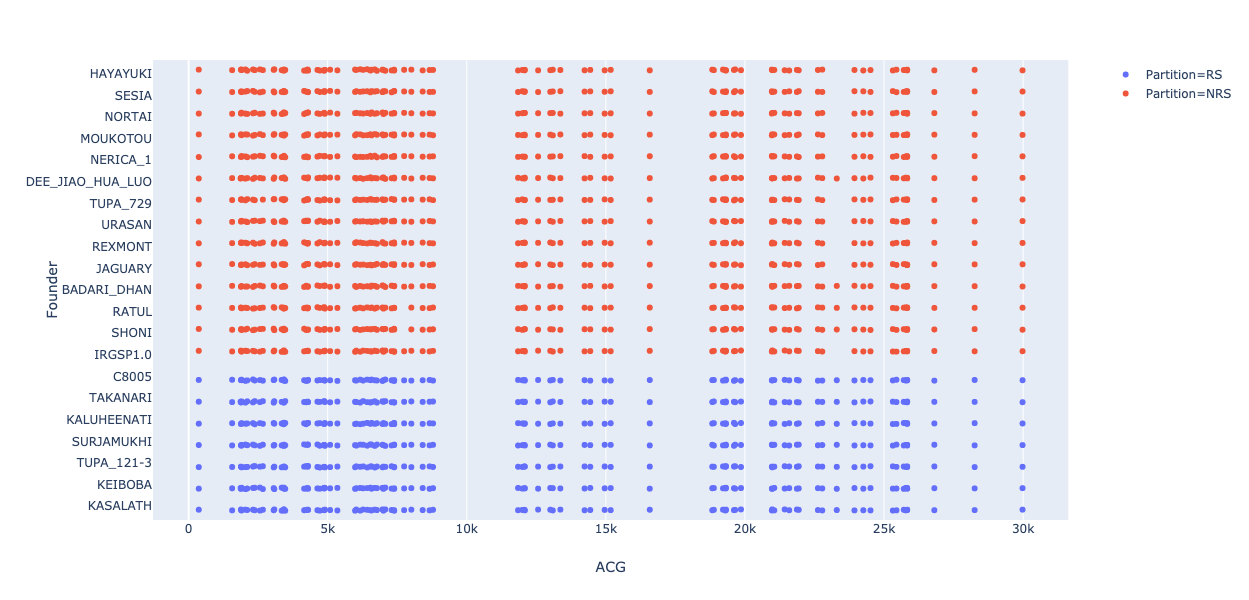

In [32]:
fig = px.strip(df_3mers, x='ACG', y='Founder', color='Partition', orientation='h')
fig.show()

In [28]:
df_3mers = pd.DataFrame()

for f in RS_3mers:
    df_3mers = pd.concat([df_3mers, pd.DataFrame({'CGC': RS_3mers[f]['CGC'],
                                                  'Founder': [f for i in range(0, len(RS_3mers[f]['CGC']))],
                                                  'Partition': ['RS' for i in range(0, len(RS_3mers[f]['CGC']))]})], axis=0)

for f in NRS_3mers:
    df_3mers = pd.concat([df_3mers, pd.DataFrame({'CGC': NRS_3mers[f]['CGC'],
                                                  'Founder': [f for i in range(0, len(NRS_3mers[f]['CGC']))],
                                                  'Partition': ['NRS' for i in range(0, len(NRS_3mers[f]['CGC']))]})], axis=0)

df_3mers = df_3mers.reset_index()

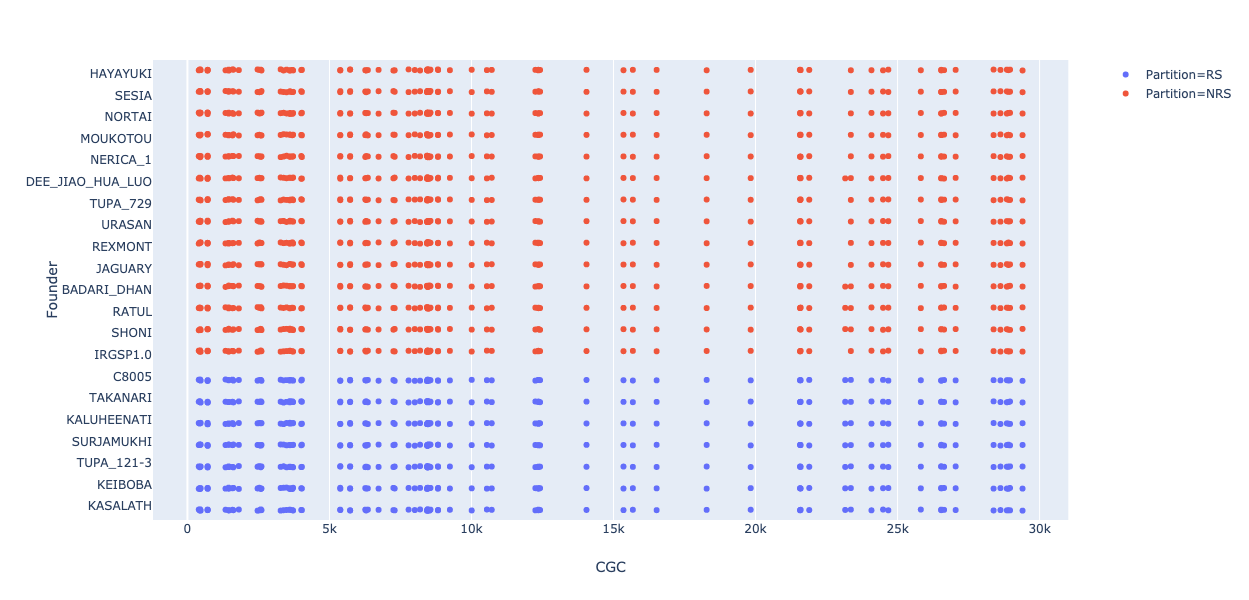

In [29]:
fig = px.strip(df_3mers, x='CGC', y='Founder', color='Partition', orientation='h')
fig.show()